In [1]:
# Load libraries
import sqlite3 # sql querying
import numpy as np # linear algebra
import pandas as pd # data processing and wrangling
import os # facilitates interaction with underlying operating system
import seaborn as sns # data visualisation 
import matplotlib.pyplot as plt # further data visualisation 
import statsmodels as sm
from sklearn.preprocessing import StandardScaler

# Some quick Pandas configuration:
pd.set_option('display.max_colwidth', None)  # Ensures full column content is shown
pd.set_option('display.max_columns', None)   # Ensures all columns are shown

# Some quick Seaborn configuration:
sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")

# Now we will load the dataset put it into an SQL database and then query it using sqlite3:
# load dataset
df = pd.read_csv('/kaggle/input/indian-marriage-and-divorce-dataset/marriage_divorce_india_with_id.csv')

# Create SQLite database
conn = sqlite3.connect('example.db')

# Save dataset as a table
df.to_sql('indian_marriage_divorce', conn, if_exists='replace', index=False)

# enable SQL Magic
%reload_ext sql

# connect to sqliite database
%sql sqlite:///example.db

In [4]:
# First lets find out the length of the dataset:
total_rows_query = """
                SELECT COUNT(*) AS total_rows
                FROM indian_marriage_divorce;
                """
row_count = pd.read_sql_query(total_rows_query, conn)
print(f"The table contains {row_count.iloc[0,0]} rows.")

# Lets also print the size of the dataset:
file_path = "/kaggle/input/indian-marriage-and-divorce-dataset/marriage_divorce_india_with_id.csv"
file_size = os.path.getsize(file_path)
print(f"The dataset is {file_size/1000} MB.")

The table contains 1200 rows.
The dataset is 72.134 MB.


Let's bring in the dataset, and see what variables it captures:

In [97]:
full_table_query = """
            SELECT * 
            FROM indian_marriage_divorce 
            ORDER BY "Income Level (INR per month)" ASC;
            """
full_table = pd.read_sql_query(full_table_query, conn)
print(full_table.info())
full_table

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Unique ID                     1200 non-null   object
 1   Marriage Duration (Years)     1200 non-null   int64 
 2   Age at Marriage               1200 non-null   int64 
 3   Marriage Type                 1200 non-null   object
 4   Education Level               1200 non-null   object
 5   Income Level (INR per month)  1200 non-null   int64 
 6   Caste/Religion                1200 non-null   object
 7   Urban/Rural                   1200 non-null   object
 8   Family Involvement            1200 non-null   object
 9   Children                      1200 non-null   int64 
 10  Divorce Status                1200 non-null   object
dtypes: int64(4), object(7)
memory usage: 103.2+ KB
None


,Unique ID,Marriage Duration (Years),Age at Marriage,Marriage Type,Education Level,Income Level (INR per month),Caste/Religion,Urban/Rural,Family Involvement,Children,Divorce Status
0,MD522,37,30,Arranged,No Education,5287,Jain,Urban,Low,1,Yes
1,MD549,1,19,Love,Postgraduate,5320,Christian,Rural,Moderate,2,Yes
2,MD872,1,25,Arranged,Secondary,5390,Other,Rural,Low,4,Yes
3,MD900,25,34,Love,Postgraduate,5507,Jain,Urban,Low,1,No
4,MD1012,26,34,Arranged,Secondary,5924,Jain,Urban,Low,0,No
...,...,...,...,...,...,...,...,...,...,...,...
1195,MD614,18,27,Arranged,Primary,199549,Jain,Urban,Moderate,0,No
1196,MD1161,1,24,Love,No Education,199795,Sikh,Urban,Moderate,4,No
1197,MD366,9,18,Love,Postgraduate,199840,Hindu,Urban,Moderate,0,No
1198,MD973,9,19,Love,Primary,199923,Christian,Rural,High,4,Yes


# Exploratory Data Analysis (EDA):
Let's get a feel for this dataset, what does it contain? Knowing this we can begin to structure the questions that we can ask of it. This will facilitate efficient analysis. 

Whilst the columns with continious data like *Income*,*Age at Marriage*, and *Marriage Duration* are quick to understand. It would be prudent to understand the **unique** values contained in other feature columns such as *Eductation* etc. So we will be looking into what these are and the distribution of the data.

In [6]:
# Unique values query
unique_categorical_query = """
    SELECT 
        REPLACE(GROUP_CONCAT(DISTINCT "Marriage Type"), ',', ', ') AS Marriage_Type,
        REPLACE(GROUP_CONCAT(DISTINCT "Education Level"), ',', ', ') AS Education_Level,
        REPLACE(GROUP_CONCAT(DISTINCT "Caste/Religion"), ',', ', ') AS Caste_Religion,
        REPLACE(GROUP_CONCAT(DISTINCT "Urban/Rural"), ',', ', ') AS Urban_Rural,
        REPLACE(GROUP_CONCAT(DISTINCT "Family Involvement"), ',', ', ') AS Family_Involvement,
        REPLACE(GROUP_CONCAT(DISTINCT "Divorce Status"), ',', ', ') AS Divorce_Status
    FROM indian_marriage_divorce;
                            """

unique_categorical_table = pd.read_sql_query(unique_categorical_query, conn)
unique_categorical_table.T

,0
Marriage_Type,"Love, Arranged"
Education_Level,"Secondary, No Education, Postgraduate, Graduate, Primary"
Caste_Religion,"Hindu, Jain, Muslim, Christian, Other, Sikh"
Urban_Rural,"Rural, Urban"
Family_Involvement,"Moderate, High, Low"
Divorce_Status,"No, Yes"


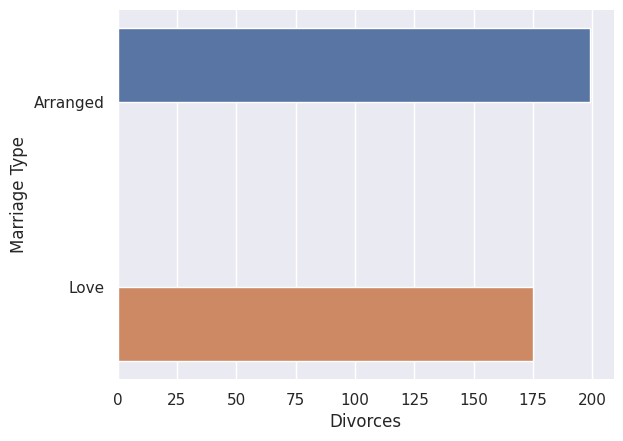

In [14]:
marriage_type_agg_query = """
                        SELECT 
                            "Marriage Type",
                            COUNT("Divorce Status") as Divorces
                        FROM 
                            indian_marriage_divorce
                        WHERE "Divorce Status" LIKE "Yes"
                        GROUP BY "Marriage Type";
                        """
marriage_type_agg_table = pd.read_sql_query(marriage_type_agg_query, conn)
marriage_type_agg_table
# Plot the total divorces
sns.barplot(y="Marriage Type", x="Divorces", data=marriage_type_agg_table,
            hue="Marriage Type")
sns.despine(left=True, bottom=True)
plt.legend([], [], frameon=False);


In [7]:
# Columns of interest: Marriage Duration (Years), Age at Marriage, Income Level (INR per month), Children
quantitative_query = """
    SELECT 
        "Marriage Duration (Years)", 
        "Age at Marriage", 
        "Income Level (INR per month)",
        "Children"
    FROM indian_marriage_divorce;  
                    """
quantitative_table = pd.read_sql_query(quantitative_query, conn)

# Get descriptive statistics:
quantitative_ds_table = quantitative_table.describe()

# Calculate IQR and add it to the table:
iqr_values = [] # Create an empty IQR list to store the values
# Loop through the cols calculating the IQR for each col and storing it in the list.
for col in quantitative_table:
    q1 = quantitative_table[col].quantile(0.25)
    q3 = quantitative_table[col].quantile(0.75)
    iqr = q3-q1
    iqr_values.append(iqr)
# Insert the IQR values into the table:
quantitative_ds_table.loc["iqr"] = iqr_values
quantitative_ds_table

,Marriage Duration (Years),Age at Marriage,Income Level (INR per month),Children
count,1200.000000,1200.000000,1200.00000,1200.000000
mean,20.553333,26.055000,102353.21250,1.885833
std,11.468512,4.891003,55761.10746,1.453580
min,1.000000,18.000000,5287.00000,0.000000
25%,10.000000,22.000000,54522.00000,1.000000
50%,22.000000,26.000000,101888.50000,2.000000
75%,30.000000,30.000000,150568.75000,3.000000
max,39.000000,34.000000,199999.00000,4.000000
iqr,20.000000,8.000000,96046.75000,2.000000


One quick point of interest would be to see whether the type of marriage, arranged or out of love, affects the likelihood of divorce. 

Now let's take a further look at the distribution of data points:

<ipython-input-35-ef61554ee9f7>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  v.set_yticklabels(ylabels)


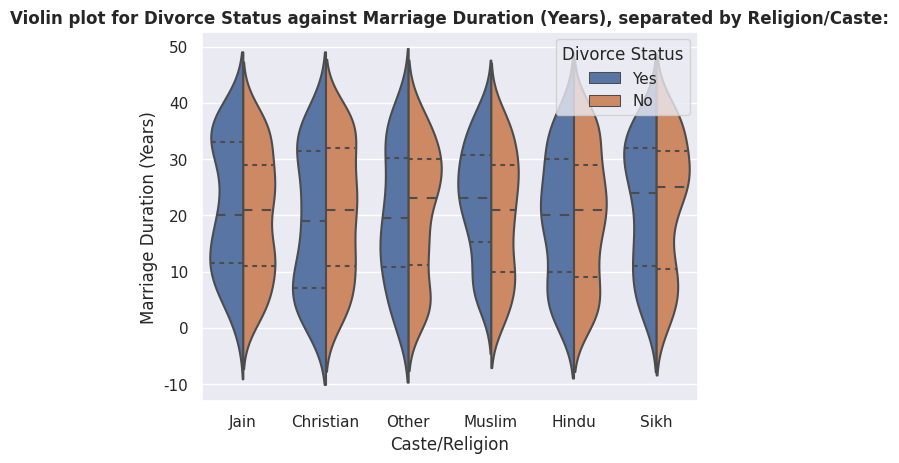

<ipython-input-35-ef61554ee9f7>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  v.set_yticklabels(ylabels)


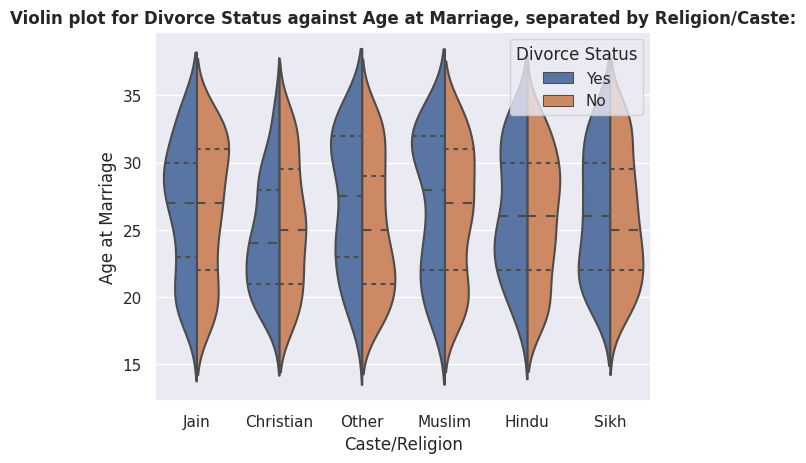

<ipython-input-35-ef61554ee9f7>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  v.set_yticklabels(ylabels)


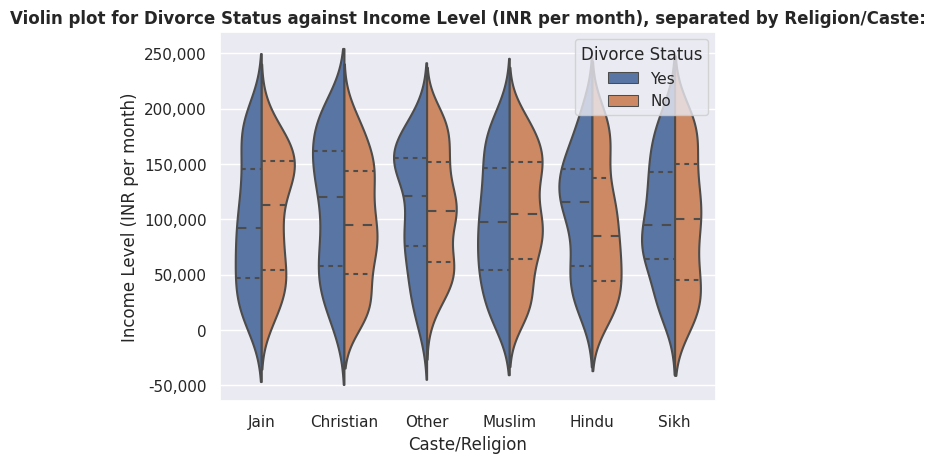

<ipython-input-35-ef61554ee9f7>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  v.set_yticklabels(ylabels)


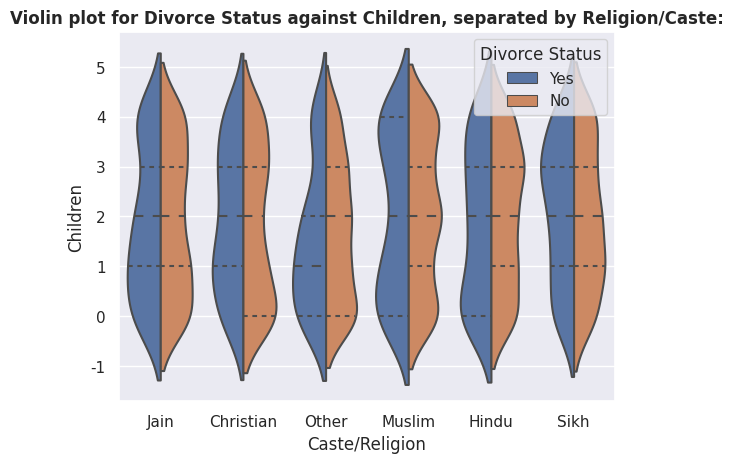

In [35]:
numeric_cols = ['Marriage Duration (Years)', 'Age at Marriage',	'Income Level (INR per month)', 'Children']
for col in numeric_cols:
    # draw a nested voiolin plot for col, divorce status and religion:
    v = sns.violinplot(data=full_table, x="Caste/Religion", y=col, hue="Divorce Status",
                   split=True, inner = "quart", fill=True)
    ylabels = [f'{int(tick):,}' for tick in v.get_yticks()]
    v.set_yticklabels(ylabels)
    plt.title(f"Violin plot for Divorce Status against {col}, separated by Religion/Caste:", fontweight='bold')
    plt.show();

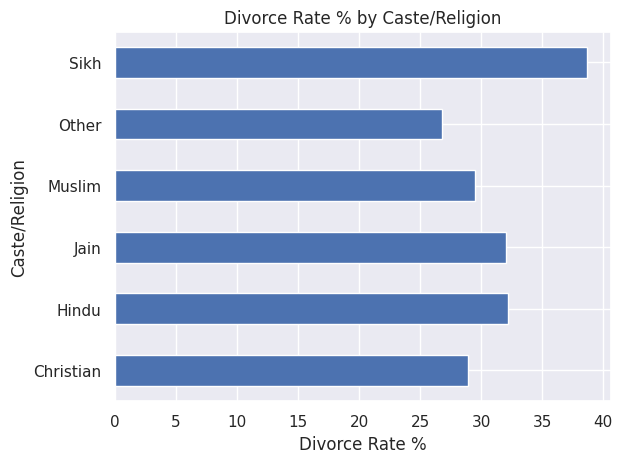

In [140]:
# Divorce Rate Vis.:
divorce_rate_by_religion = full_table.groupby("Caste/Religion")["Divorce Status Numeric"].mean()*100
divorce_rate_by_religion.plot(kind='barh', xlabel="Divorce Rate %", title = "Divorce Rate % by Caste/Religion");


# Logistic Regressions:

In [149]:
# Prep the dataset:
# Divorce Status encoding to numeric:
divorce_status_mappings = {"Yes": 1, "No": 0}
full_table['Divorce Status Numeric'] = full_table["Divorce Status"].map(divorce_status_mappings) 
dummies = pd.get_dummies(full_table[['Marriage Type', 'Education Level', 'Caste/Religion', 'Urban/Rural', 'Family Involvement']])
dummy_mappings = {True:1, False:0}
for col in dummies:
    dummies[col]=dummies[col].map(dummy_mappings)
df = pd.concat([full_table, dummies], axis=1)
df.drop(df[['Unique ID','Marriage Type', 'Education Level', 'Caste/Religion', 'Urban/Rural', 'Family Involvement', 'Divorce Status']], axis=1, inplace=True)

df.head()

,Marriage Duration (Years),Age at Marriage,Income Level (INR per month),Children,Divorce Status Numeric,Marriage Type_Arranged,Marriage Type_Love,Education Level_Graduate,Education Level_No Education,Education Level_Postgraduate,Education Level_Primary,Education Level_Secondary,Caste/Religion_Christian,Caste/Religion_Hindu,Caste/Religion_Jain,Caste/Religion_Muslim,Caste/Religion_Other,Caste/Religion_Sikh,Urban/Rural_Rural,Urban/Rural_Urban,Family Involvement_High,Family Involvement_Low,Family Involvement_Moderate
0,37,30,5287,1,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0
1,1,19,5320,2,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1
2,1,25,5390,4,1,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0
3,25,34,5507,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
4,26,34,5924,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0


In [150]:
# Set up the Independent and Dependent Variables:
X = df.drop(columns = 'Divorce Status Numeric')
y = df['Divorce Status Numeric']

# Set up the Test Train Split:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the continuous variables:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[['Marriage Duration (Years)', 'Age at Marriage', 'Income Level (INR per month)', 'Children']])
X_test_scaled = scaler.transform(X_test[['Marriage Duration (Years)', 'Age at Marriage', 'Income Level (INR per month)', 'Children']])

# Replace the unscaled continuous data with scaled versions:
X_train[['Marriage Duration (Years)', 'Age at Marriage', 'Income Level (INR per month)', 'Children']] = X_train_scaled
X_test[['Marriage Duration (Years)', 'Age at Marriage', 'Income Level (INR per month)', 'Children']] = X_test_scaled


In [154]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

In [167]:
# Coefficients interpretation
coefficients = pd.DataFrame(model.coef_.flatten(), X.columns, columns=["Coefficient"])
coefficients

,Coefficient
Marriage Duration (Years),-0.002957
Age at Marriage,0.056895
Income Level (INR per month),0.125173
Children,-0.104888
Marriage Type_Arranged,0.005923
Marriage Type_Love,-0.005966
Education Level_Graduate,0.082318
Education Level_No Education,-0.080430
Education Level_Postgraduate,-0.023498
Education Level_Primary,0.128446


In [168]:
import statsmodels.api as sm

# Add an intercept column
X_train_sm = sm.add_constant(X_train)

# Fit logistic regression
logit_model = sm.Logit(y_train, X_train_sm).fit()

# Print summary with coefficients, standard errors, t-stats, and p-values
print(logit_model.summary())


         Current function value: 0.607210
         Iterations: 35
                             Logit Regression Results                             
Dep. Variable:     Divorce Status Numeric   No. Observations:                  960
Model:                              Logit   Df Residuals:                      942
Method:                               MLE   Df Model:                           17
Date:                    Mon, 27 Jan 2025   Pseudo R-squ.:                 0.01573
Time:                            20:22:38   Log-Likelihood:                -582.92
converged:                          False   LL-Null:                       -592.24
Covariance Type:                nonrobust   LLR p-value:                    0.3498
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -0.3021   5.92e+06  -5.11e-08      1.000   -

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [170]:
X_train.columns

Index(['Marriage Duration (Years)', 'Age at Marriage',
       'Income Level (INR per month)', 'Children', 'Marriage Type_Arranged',
       'Marriage Type_Love', 'Education Level_Graduate',
       'Education Level_No Education', 'Education Level_Postgraduate',
       'Education Level_Primary', 'Education Level_Secondary',
       'Caste/Religion_Christian', 'Caste/Religion_Hindu',
       'Caste/Religion_Jain', 'Caste/Religion_Muslim', 'Caste/Religion_Other',
       'Caste/Religion_Sikh', 'Urban/Rural_Rural', 'Urban/Rural_Urban',
       'Family Involvement_High', 'Family Involvement_Low',
       'Family Involvement_Moderate'],
      dtype='object')

In [174]:
# Divorce and Age at Marriage
X_train_AaM = X_train['Age at Marriage']
X_test_AaM = X_test['Age at Marriage']

# Add an intercept column
X_train_AaM = sm.add_constant(X_train_AaM)

# Fit logistic regression
logit_model_AaM = sm.Logit(y_train, X_train_AaM).fit()

# Print summary with coefficients, standard errors, t-stats, and p-values
print(logit_model_AaM.summary())


Optimization terminated successfully.
         Current function value: 0.616631
         Iterations 5
                             Logit Regression Results                             
Dep. Variable:     Divorce Status Numeric   No. Observations:                  960
Model:                              Logit   Df Residuals:                      958
Method:                               MLE   Df Model:                            1
Date:                    Mon, 27 Jan 2025   Pseudo R-squ.:               0.0004627
Time:                            20:31:50   Log-Likelihood:                -591.97
converged:                           True   LL-Null:                       -592.24
Covariance Type:                nonrobust   LLR p-value:                    0.4591
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.8133      0.070    -11.621      0.000      -

In [175]:
# Divorce and Marriage Duration
X_train_MD = X_train['Marriage Duration (Years)']
X_test_MD = X_test['Marriage Duration (Years)']

# Add an intercept column
X_train_MD = sm.add_constant(X_train_MD)

# Fit logistic regression
logit_model_MD = sm.Logit(y_train, X_train_MD).fit()

# Print summary with coefficients, standard errors, t-stats, and p-values
print(logit_model_MD.summary())

Optimization terminated successfully.
         Current function value: 0.616913
         Iterations 5
                             Logit Regression Results                             
Dep. Variable:     Divorce Status Numeric   No. Observations:                  960
Model:                              Logit   Df Residuals:                      958
Method:                               MLE   Df Model:                            1
Date:                    Mon, 27 Jan 2025   Pseudo R-squ.:               6.412e-06
Time:                            20:31:52   Log-Likelihood:                -592.24
converged:                           True   LL-Null:                       -592.24
Covariance Type:                nonrobust   LLR p-value:                    0.9306
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.8128      0.07

In [173]:
# Divorce and Income
X_train_I = X_train['Income Level (INR per month)']
X_test_I = X_test['Income Level (INR per month)']

# Add an intercept column
X_train_I = sm.add_constant(X_train_I)

# Fit logistic regression
logit_model_I = sm.Logit(y_train, X_train_I).fit()

# Print summary with coefficients, standard errors, t-stats, and p-values
print(logit_model_I.summary())

Optimization terminated successfully.
         Current function value: 0.615487
         Iterations 5
                             Logit Regression Results                             
Dep. Variable:     Divorce Status Numeric   No. Observations:                  960
Model:                              Logit   Df Residuals:                      958
Method:                               MLE   Df Model:                            1
Date:                    Mon, 27 Jan 2025   Pseudo R-squ.:                0.002316
Time:                            20:31:22   Log-Likelihood:                -590.87
converged:                           True   LL-Null:                       -592.24
Covariance Type:                nonrobust   LLR p-value:                   0.09763
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -0.8154 

In [176]:
# Divorce and No. Children
X_train_C = X_train['Children']
X_test_C = X_test['Children']

# Add an intercept column
X_train_C = sm.add_constant(X_train_C)

# Fit logistic regression
logit_model_C = sm.Logit(y_train, X_train_C).fit()

# Print summary with coefficients, standard errors, t-stats, and p-values
print(logit_model_C.summary())

Optimization terminated successfully.
         Current function value: 0.615880
         Iterations 5
                             Logit Regression Results                             
Dep. Variable:     Divorce Status Numeric   No. Observations:                  960
Model:                              Logit   Df Residuals:                      958
Method:                               MLE   Df Model:                            1
Date:                    Mon, 27 Jan 2025   Pseudo R-squ.:                0.001680
Time:                            20:32:48   Log-Likelihood:                -591.24
converged:                           True   LL-Null:                       -592.24
Covariance Type:                nonrobust   LLR p-value:                    0.1583
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8147      0.070    -11.626      0.000      -0.952      -0.6

In [179]:
# Divorce and Cont. Variables:
X_train_Cont = X_train[['Marriage Duration (Years)', 'Age at Marriage',
       'Income Level (INR per month)', 'Children']]
X_test_Cont = X_test[['Marriage Duration (Years)', 'Age at Marriage',
       'Income Level (INR per month)', 'Children']
]
# Add an intercept column
X_train_Cont = sm.add_constant(X_train_Cont)

# Fit logistic regression
logit_model_Cont = sm.Logit(y_train, X_train_Cont).fit()

# Print summary with coefficients, standard errors, t-stats, and p-values
print(logit_model_Cont.summary())


Optimization terminated successfully.
         Current function value: 0.614176
         Iterations 5
                             Logit Regression Results                             
Dep. Variable:     Divorce Status Numeric   No. Observations:                  960
Model:                              Logit   Df Residuals:                      955
Method:                               MLE   Df Model:                            4
Date:                    Mon, 27 Jan 2025   Pseudo R-squ.:                0.004443
Time:                            20:34:36   Log-Likelihood:                -589.61
converged:                           True   LL-Null:                       -592.24
Covariance Type:                nonrobust   LLR p-value:                    0.2614
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -0.8178 

# Logistic Regression?